In [1]:
%matplotlib inline

# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pickle
from copy import deepcopy

# Import local paths
import sys, os
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs import Perception
from lcs.metrics import population_metrics
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_grid

In [2]:
# Papermill notebook params
env = 'grid-10-v0'
trials = 100_000
decay = False

# Grid

Actions:

    MOVE_LEFT = 0
    MOVE_RIGHT = 1
    MOVE_UP = 2
    MOVE_DOWN = 3


In [3]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable() and cl.does_anticipate_change()])

# collect more metrics
def grid_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [4]:
cfg = Configuration(
        classifier_length=2,
        number_of_possible_actions=4,
        epsilon=1.0,
        beta=0.01,
        gamma=0.9,
        theta_i=0.1,
        theta_as=20,
        theta_exp=50,
        theta_ga=30,
        do_ga=True,
        mu=0.04,
        u_max=2,
        metrics_trial_frequency=10,
        user_metrics_collector_fcn=grid_metrics)

In [5]:
def print_cl(cl):
    action = None
    if cl.action == 0:
        action = '⬅'
    if cl.action == 1:
        action = '➡'
    if cl.action == 2:
        action = '⬆'
    if cl.action == 3:
        action = '⬇'
    print(f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}], exp: {cl.exp}")

In [6]:
def print_simple_stats(population, metrics):
    pop_size = len(population)
    
    # avg step in trial
    steps = []
    for m in metrics:
        steps.append(m['steps_in_trial'])

    print(f"Population of {pop_size}, avg steps {sum(steps)/len(steps)}, all steps {sum(steps)}")     

In [7]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['population'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='macro')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

In [8]:
def plot_avg_fitness(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    avg_fitness = [m['avg_fitness'] for m in metrics]
    
    ax.plot(trials, avg_fitness, 'b')
    
    ax.set_title("Average fitness")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Fitness value")

## Grid

### Experiments

In [9]:
print(f'Running {trials} trials on [{env}], decay={decay}')

Running 100000 trials on [grid-10-v0], decay=False


In [10]:
grid = gym.make(env)

In [11]:
%%time
agent = ACS2(cfg)
population, metrics = agent.explore(grid, trials, decay=decay)

/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 762, 'reward': 1000, 'avg_fitness': nan, 'population': 42, 'numerosity': 322, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 667, 'reward': 1000, 'avg_fitness': 159.34619878894978, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 348, 'reward': 1000, 'avg_fitness': 158.1843603171464, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 425, 'reward': 1000, 'avg_fitness': 159.28379693458075, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agent

CPU times: user 3h 35min 57s, sys: 2min 12s, total: 3h 38min 10s
Wall time: 3h 37min 48s


In [12]:
print_simple_stats(population, metrics)

Population of 40, avg steps 504.5288, all steps 5045288


In [13]:
for cl in sorted(population, key=lambda cl: -cl.fitness):
    print_cl(cl)

9# - ➡ - 10# [fit: 218.373, r: 218.37, ir: 49.63], exp: 1072463
#9 - ⬆ - #10 [fit: 218.309, r: 218.31, ir: 32.23], exp: 1074016
#8 - ⬆ - #9 [fit: 213.384, r: 213.38, ir: 0.00], exp: 1152492
#10 - ⬇ - #9 [fit: 211.730, r: 211.73, ir: 0.00], exp: 985348
#7 - ⬆ - #8 [fit: 193.552, r: 193.55, ir: 0.00], exp: 1221463
#9 - ⬇ - #8 [fit: 192.954, r: 192.95, ir: 0.00], exp: 1073772
#10 - ⬆ - ## [fit: 191.909, r: 191.91, ir: 0.00], exp: 985980
8# - ➡ - 9# [fit: 190.235, r: 190.24, ir: 0.00], exp: 1153807
10# - ⬅ - 9# [fit: 189.499, r: 189.50, ir: 0.00], exp: 983611
7# - ➡ - 8# [fit: 184.114, r: 184.11, ir: 0.00], exp: 1222495
9# - ⬅ - 8# [fit: 178.698, r: 178.70, ir: 0.00], exp: 1074789
6# - ➡ - 7# [fit: 177.354, r: 177.35, ir: 0.00], exp: 1279014
10# - ➡ - ## [fit: 176.942, r: 176.94, ir: 0.00], exp: 983160
8# - ⬅ - 7# [fit: 176.700, r: 176.70, ir: 0.00], exp: 1153375
#6 - ⬆ - #7 [fit: 172.234, r: 172.23, ir: 0.00], exp: 1281924
7# - ⬅ - 6# [fit: 171.676, r: 171.68, ir: 0.00], exp: 1219724
5# -

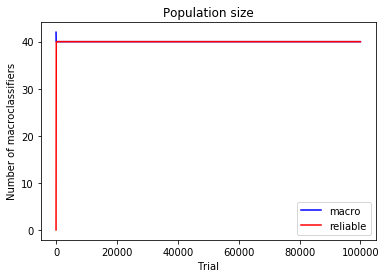

In [14]:
plot_population(metrics)

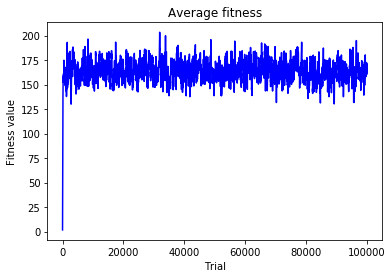

In [15]:
plot_avg_fitness(metrics)

### Pure exploitation

In [16]:
%%time
agent = ACS2(cfg, deepcopy(population))
pop_exploit, metric_exploit = agent.exploit(grid, 500)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 648, 'reward': 1000, 'avg_fitness': 170.1996228321526, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 86, 'reward': 1000, 'avg_fitness': 133.5599116476698, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 123, 'reward': 1000, 'avg_fitness': 101.62425211960115, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 150, 'steps_in_trial': 49, 'reward': 1000, 'avg_fitness': 76.94733481584355, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 60, 'reward': 1000, 'avg_fitness': 60.802714211540284, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'trial': 250, 'steps_in_trial': 2000, 'reward': 0, 'avg_fitness': 44.79833161992301, 'population': 40, 'numerosity': 800, 'reliable': 40}
INFO:lcs.agents.Agent:{'tria

CPU times: user 37.2 s, sys: 35.9 ms, total: 37.2 s
Wall time: 37.2 s


In [17]:
print_simple_stats(pop_exploit, metric_exploit)

Population of 40, avg steps 900.38, all steps 45019


In [18]:
for cl in sorted(pop_exploit, key=lambda cl: -cl.fitness):
    print_cl(cl)

#10 - ⬆ - ## [fit: 191.909, r: 191.91, ir: 0.00], exp: 985980
10# - ➡ - ## [fit: 176.942, r: 176.94, ir: 0.00], exp: 983160
1# - ⬅ - ## [fit: 164.058, r: 164.06, ir: 0.00], exp: 1423377
#1 - ⬇ - ## [fit: 157.251, r: 157.25, ir: 0.00], exp: 1425980
9# - ➡ - 10# [fit: 11.292, r: 11.29, ir: 10.00], exp: 1072463
#8 - ⬆ - #9 [fit: 1.358, r: 1.36, ir: 0.00], exp: 1152492
#8 - ⬇ - #7 [fit: 1.345, r: 1.35, ir: 0.00], exp: 1152554
#7 - ⬆ - #8 [fit: 1.343, r: 1.34, ir: 0.00], exp: 1221463
#7 - ⬇ - #6 [fit: 1.342, r: 1.34, ir: 0.00], exp: 1222852
#6 - ⬇ - #5 [fit: 1.328, r: 1.33, ir: 0.00], exp: 1281433
#6 - ⬆ - #7 [fit: 1.328, r: 1.33, ir: 0.00], exp: 1281924
#5 - ⬇ - #4 [fit: 1.319, r: 1.32, ir: 0.00], exp: 1332317
#5 - ⬆ - #6 [fit: 1.319, r: 1.32, ir: 0.00], exp: 1330605
8# - ⬅ - 7# [fit: 1.318, r: 1.32, ir: 0.00], exp: 1153375
8# - ➡ - 9# [fit: 1.317, r: 1.32, ir: 0.00], exp: 1153807
#4 - ⬇ - #3 [fit: 1.314, r: 1.31, ir: 0.00], exp: 1365560
#4 - ⬆ - #5 [fit: 1.314, r: 1.31, ir: 0.00], exp: 13

### Manual tests

In [19]:
state = Perception(("5","10"))

match = pop_exploit.form_match_set(state)
for cl in sorted(match, key=lambda cl: -cl.fitness):
        if cl.does_anticipate_change():
            print_cl(cl)
#         else:
#             print_cl(cl)

5# - ⬅ - 4# [fit: 1.304, r: 1.30, ir: 0.00], exp: 1328939
5# - ➡ - 6# [fit: 1.303, r: 1.30, ir: 0.00], exp: 1327248
#10 - ⬇ - #9 [fit: 1.299, r: 1.30, ir: 0.00], exp: 985348


In [20]:
import random

def find_best_moves(population, state):
    def best_fitness(match_set, action):
        action_set = [cl for cl in match_set.form_action_set(action) if cl.does_anticipate_change()]
        random.shuffle(action_set)  # in case there are many actions available
        if len(action_set):
            best_cl = max(action_set, key=lambda cl: cl.fitness)
            return best_cl.fitness
        else:
            return 0  # if classifier predicts no change it's fitness is set to 0
    
    matching = population.form_match_set(state)
    
    return {
        "left": best_fitness(matching, 0),
        "right": best_fitness(matching, 1),
        "up": best_fitness(matching, 2),
        "down": best_fitness(matching, 3)
        
    }

find_best_moves(population, Perception(("1", "1")))

{'left': 0, 'right': 165.46201913941718, 'up': 157.31325833813028, 'down': 0}

In [21]:
dim = 10
step = 1. / dim

states = []

for x in range(0, dim):
    for y in range(0, dim):
        states.append({
            "pos": (x * step, y * step),
            "cord": (x+1, y+1),
            "best": find_best_moves(population, Perception((str(x+1), str(y+1))))
        })

# show first one
states[:1]

[{'pos': (0.0, 0.0),
  'cord': (1, 1),
  'best': {'left': 0,
   'right': 165.46201913941718,
   'up': 157.31325833813028,
   'down': 0}}]

In [22]:
from itertools import chain

fitness_values = list()
for s in states:
    for v in s['best'].values():
        if v is not None:
            fitness_values.append(v)

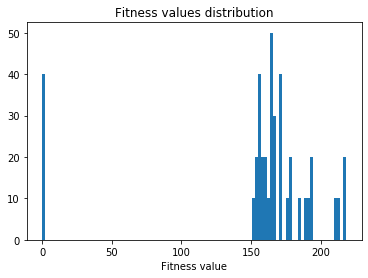

In [23]:
plt.hist(fitness_values, bins=100)
plt.title('Fitness values distribution')
plt.xlabel('Fitness value')
plt.show()

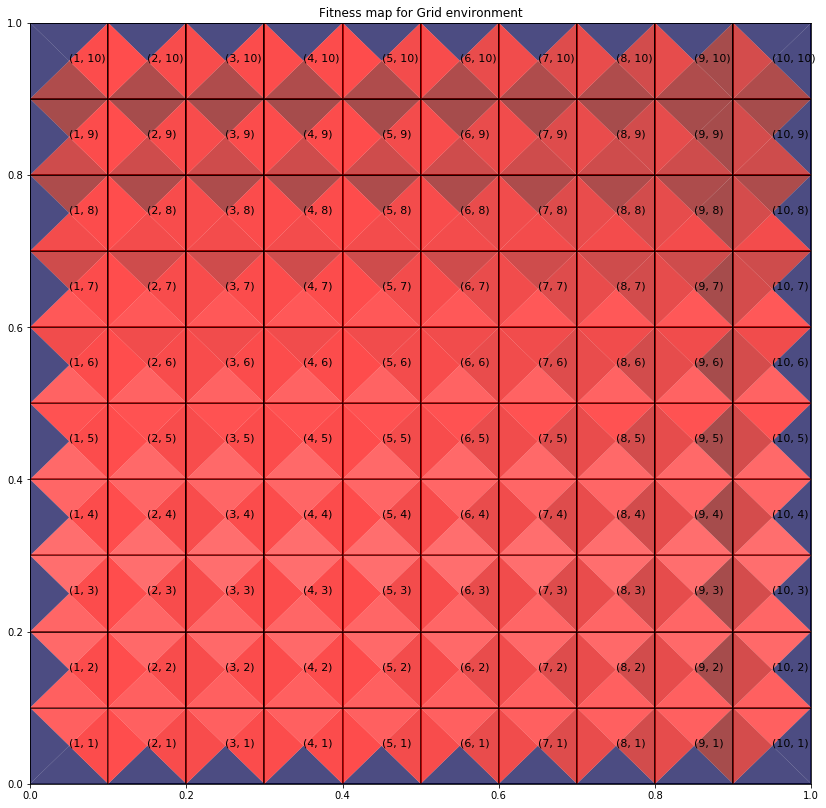

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx


cm = plt.get_cmap('seismic')
cNorm  = colors.Normalize(vmin=min(fitness_values), vmax=max(fitness_values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(1, figsize=(14,14))

ax.set_title('Fitness map for Grid environment')
for state in states:
    (pos_x, pos_y) = state['pos']
    rect = patches.Rectangle((pos_x, pos_y), .2, .2, linewidth=2, edgecolor='black', facecolor='none', alpha=.7)
    
    alpha_triangles = 0.7
    
    down = plt.Polygon([(pos_x, pos_y), (pos_x+step, pos_y), (pos_x+step/2, pos_y+step/2)],
                       color=scalarMap.to_rgba(state['best']['down']),
                       alpha=alpha_triangles,linewidth=0)
    up = plt.Polygon([(pos_x, pos_y+step), (pos_x+step, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['up']),
                     alpha=alpha_triangles, linewidth=0)
    left = plt.Polygon([(pos_x, pos_y), (pos_x, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['left']),
                     alpha=alpha_triangles, linewidth=0)
    right = plt.Polygon([(pos_x+step, pos_y), (pos_x+step, pos_y+step), (pos_x+step/2, pos_y+step/2)],
                     color=scalarMap.to_rgba(state['best']['right']),
                     alpha=alpha_triangles, linewidth=0)
    
    plt.text(pos_x+step/2, pos_y+step/2, state['cord'], fontsize=11)  # cords
    
#     plt.text(pos_x+.07, pos_y+0.008,
#              round(state['best']['down'], 5),
#              fontsize=8)
#     plt.text(pos_x+.07, pos_y+0.18,
#              round(state['best']['up'], 5),
#              fontsize=8)
#     plt.text(pos_x+0.008, pos_y+0.07,
#              round(state['best']['left'], 5),
#              fontsize=8,
#              rotation=90)
#     plt.text(pos_x+0.17, pos_y+0.07,
#              round(state['best']['right'], 5),
#              fontsize=8,
#              rotation=-90)
    
    ax.add_patch(rect)
    ax.add_patch(down)
    ax.add_patch(up)
    ax.add_patch(left)
    ax.add_patch(right)

plt.show()

Save population and metrics

In [25]:
filename = f'{env}_{trials}_trials_decay_{decay}.pickle'
with open(filename, 'wb') as f:
    pickle.dump((population, metrics), f)